In [1]:
import torch
import models_vit
from util.pos_embed import interpolate_pos_embed
from timm.models.layers import trunc_normal_
import h5py
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import glob
import torch.nn as nn
from PIL import Image


Image name: b'1092630_21015_0_0.png'


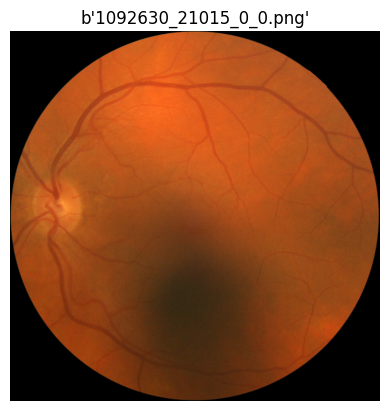

In [2]:
# 从一个hdf5文件中提取图像 进行观察
import h5py
import numpy as np
import matplotlib.pyplot as plt

# 指定HDF5文件的路径
hdf5_file_path = '/opt/notebooks/left10p.hdf5'

# 打开HDF5文件
with h5py.File(hdf5_file_path, 'r') as hdf:
    # 提取图像名称
    image_names = hdf['image_names'][:]
    
    # 提取图像数据
    images_group = hdf['images']
    
    # 打印提取的图像名称
    for img_name in image_names:
        print(f"Image name: {img_name}")
        
        # 提取并显示图像
        img_data = images_group[img_name][:]
        
        # 显示图像
        plt.imshow(img_data)
        plt.title(img_name)
        plt.axis('off')
        plt.show()
        break

In [3]:
# 使用bytes格式的名字来提取图像
with h5py.File('/opt/notebooks/left10p.hdf5', 'r') as hdf:
     # 提取图像名称
    image_name_str = b'1092630_21015_0_0.png'
    # 提取图像数据
    images_group = hdf['images']
    
    img = images_group[image_name_str][:]
    print(img.shape)

(800, 800, 3)


In [5]:
# 把所有hdf5文件里面的图像名作为一个列表，制作df数据集
hdf5list = hdf5list = glob.glob('/opt/notebooks/*.hdf5')

image_names = []

# 逐个读取并关闭文件，避免一次性打开过多文件
for hdf5_file in hdf5list:
    if os.path.exists(hdf5_file):
        try:
            with h5py.File(hdf5_file, 'r') as f:
                if 'image_names' in f:
                    image_names.extend(list(f['image_names']))
        except OSError as e:
            print(f"Error opening file {hdf5_file}: {e}")

print(f"Total image names: {len(image_names)}")


Total image names: 89563


In [6]:
# image name 作为 df
df1 = pd.DataFrame(image_names, columns=['image_name_bytes'])
df1['image_name'] = df1['image_name_bytes'].apply(lambda x: x.decode('utf-8'))
df1['eid'] = df1['image_name'].apply(lambda x: int(x.split('_')[0]))
df1['side'] = df1['image_name'].apply(lambda x: x.split('_')[1])
df1['hdf'] = df1['eid'].apply(lambda x: str(x)[:2])
df1['sidec'] = df1['side'].apply(lambda x: 'left' if x == '21015' else 'right')

# 加载CSV文件
csv_file = '/opt/notebooks/残差调整标签.csv'
df2 = pd.read_csv(csv_file)
# 只保留eid、split and bmi_r
df2 = df2[['eid', 'split', 'bmi_r']]

# merge by eid, keep all the df1 records
df = pd.merge(df1, df2, on='eid', how='left')

# 数据集划分信息
iv = df[df['split']=='iv']
ev = df[df['split']=='ev']
train = df[df['split']=='train']

/tmp/ipykernel_641/120027999.py:11: DtypeWarning: Columns (130,131,132,133,134,135) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(csv_file)


In [7]:
class FundusDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_name = row['image_name_bytes']
        hdf_file_name = f"{row['sidec']}{row['hdf']}p.hdf5"
        file_path = f"/opt/notebooks/{hdf_file_name}"
        
        # 打开HDF5文件并读取图像数据
        with h5py.File(file_path, 'r') as hdf:
            images_group = hdf['images']
            img_data = images_group[image_name][:]
            img_data = Image.fromarray(img_data, mode='RGB')
        
        # 如果需要进行图像变换
        if self.transform:
            img_data = self.transform(img_data)
        
        bmi_r = row['bmi_r']
        
        return img_data, bmi_r

In [8]:
from torchvision import transforms
from torch.utils.data import Subset
from timm.data import transforms
from timm.data import create_transform

# data_transforms = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize((224, 224)),  # 调整图像大小

# ])

train_transform = create_transform(
    input_size=224,             # Target input size
    is_training=True,           # Set to True for training
    auto_augment='rand-m9-mstd0.5',  # Use random auto-augment strategy
    interpolation='random',     # Random interpolation for augmentations
    mean=(0.485, 0.456, 0.406), # Mean for normalization (e.g., ImageNet statistics)
    std=(0.229, 0.224, 0.225),  # Standard deviation for normalization
    normalize=True              # Explicitly normalize the input
)

val_transform = create_transform(
    input_size=224,          # Target input size
    is_training=False,       # Set to False for validation
    mean=(0.485, 0.456, 0.406), # Mean for normalization
    std=(0.229, 0.224, 0.225),  # Standard deviation for normalization
    normalize=True           # Apply normalization
)



# 创建Dataset实例
train_dataset = FundusDataset(train, transform=train_transform)
subset_indices1 = np.random.choice(len(train_dataset), size=int(0.1 * len(train_dataset)), replace=False)
train_dataset2 = Subset(train_dataset, subset_indices1)

iv_dataset = FundusDataset(iv, transform=val_transform)
subset_indices2 = np.random.choice(len(iv_dataset), size=int(0.1 * len(iv_dataset)), replace=False)
iv_dataset2 = Subset(iv_dataset, subset_indices2)

ev_dataset = FundusDataset(ev, transform=val_transform)

# 创建DataLoader实例
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
train_loader2 = DataLoader(train_dataset2, batch_size=32, shuffle=True, num_workers=0)
iv_loader = DataLoader(iv_dataset, batch_size=32, shuffle=False, num_workers=0)
iv_loader2 = DataLoader(iv_dataset2, batch_size=32, shuffle=False, num_workers=0)
ev_loader = DataLoader(ev_dataset, batch_size=32, shuffle=False, num_workers=0)

len(train_dataset), len(train_dataset2), len(iv_dataset), len(iv_dataset2), len(ev_dataset)

(31743, 3174, 7709, 770, 49625)

In [9]:
from functools import partial
import torch
import torch.nn as nn
import timm.models.vision_transformer

class VisionTransformer(timm.models.vision_transformer.VisionTransformer):
    """ Vision Transformer with support for global average pooling
    """
    def __init__(self, global_pool='avg', **kwargs):
        super(VisionTransformer, self).__init__(**kwargs)

        if global_pool not in ['avg', 'max', False]:
            raise ValueError(f"Invalid value for global_pool: {global_pool}")
        self.global_pool = global_pool
        if self.global_pool:
            norm_layer = kwargs['norm_layer']
            embed_dim = kwargs['embed_dim']
            self.fc_norm = norm_layer(embed_dim)
            del self.norm  # remove the original norm

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        if self.global_pool:
            if self.global_pool == 'avg':
                x = x[:, 1:, :].mean(dim=1)  # global pool without cls token
            elif self.global_pool == 'max':
                x = x[:, 1:, :].max(dim=1)[0]  # global max pool without cls token
            x = self.fc_norm(x)
            # print("Shape after pooling:", x.shape)  # 添加调试信息
        else:
            x = self.norm(x)
            x = x[:, 0]

        return x
    
    def forward_head(self, x, pre_logits: bool = False) -> torch.Tensor:
        if self.global_pool:
            # print("Input shape to fc_norm:", x.shape)  # Debug info
            x = self.fc_norm(x)
            # print("Output shape from fc_norm:", x.shape)  # Debug info
        else:
            x = self.norm(x)
            x = x[:, 0]
        x = self.head_drop(x)
        return x if pre_logits else self.head(x)


def vit_large_patch16(global_pool='avg', **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), global_pool=global_pool, **kwargs)
    return model


In [10]:
# call the model
model = vit_large_patch16(global_pool='avg', num_classes=1, drop_path_rate=0.3)

# load RETFound weights
checkpoint = torch.load('/opt/notebooks/RETFound_cfp_weights.pth', map_location='cpu')
checkpoint_model = checkpoint['model']
state_dict = model.state_dict()
for k in ['head.weight', 'head.bias']:
    if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
        print(f"Removing key {k} from pretrained checkpoint")
        del checkpoint_model[k]
        
# interpolate position embedding
interpolate_pos_embed(model, checkpoint_model)
# load pre-trained model
msg = model.load_state_dict(checkpoint_model, strict=False)

assert set(msg.missing_keys) == {'head.weight', 'head.bias', 'fc_norm.weight', 'fc_norm.bias'}

# manually initialize fc layer
trunc_normal_(model.head.weight, std=2e-5)

# print("Model = %s" % str(model))

Parameter containing:
tensor([[ 1.0757e-05, -1.8123e-05, -9.4111e-06,  ..., -1.0545e-05,
         -4.5803e-06,  1.4563e-05]], requires_grad=True)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# model.eval()
# inputdata = torch.randn(256, 3, 224, 224).to(device)
# with torch.no_grad():
#     output = model(inputdata)
#     print(output)

In [12]:
def set_parameter_requires_grad(model, num_unfreeze_blocks):
    for name, param in model.named_parameters():
        if any(f'blocks.{i}' in name for i in range(num_unfreeze_blocks, 24)) or name in ['head.weight', 'head.bias', 'fc_norm.weight', 'fc_norm.bias']:
            param.requires_grad = True
        else:
            param.requires_grad = False
            
set_parameter_requires_grad(model, 12)
    
for name, param in model.named_parameters():  
    print(name, param.requires_grad)


cls_token False
pos_embed False
patch_embed.proj.weight False
patch_embed.proj.bias False
blocks.0.norm1.weight False
blocks.0.norm1.bias False
blocks.0.attn.qkv.weight False
blocks.0.attn.qkv.bias False
blocks.0.attn.proj.weight False
blocks.0.attn.proj.bias False
blocks.0.norm2.weight False
blocks.0.norm2.bias False
blocks.0.mlp.fc1.weight False
blocks.0.mlp.fc1.bias False
blocks.0.mlp.fc2.weight False
blocks.0.mlp.fc2.bias False
blocks.1.norm1.weight False
blocks.1.norm1.bias False
blocks.1.attn.qkv.weight False
blocks.1.attn.qkv.bias False
blocks.1.attn.proj.weight False
blocks.1.attn.proj.bias False
blocks.1.norm2.weight False
blocks.1.norm2.bias False
blocks.1.mlp.fc1.weight False
blocks.1.mlp.fc1.bias False
blocks.1.mlp.fc2.weight False
blocks.1.mlp.fc2.bias False
blocks.2.norm1.weight False
blocks.2.norm1.bias False
blocks.2.attn.qkv.weight False
blocks.2.attn.qkv.bias False
blocks.2.attn.proj.weight False
blocks.2.attn.proj.bias False
blocks.2.norm2.weight False
blocks.2.norm2

In [14]:
import sys
import tqdm

model = nn.DataParallel(model, device_ids=[i for i in range(torch.cuda.device_count())])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
iv_losses = []
avg_train_losses = []
avg_iv_losses = []
best_loss = 1000000
initial_epoch = 0
num_epoch_no_improvement = 0
nb_epoch = 500
patience = 30
sys.stdout.flush()

In [ ]:
for epoch in range(initial_epoch, nb_epoch):
    # model.train()
    train_loader_tqdm = tqdm.tqdm(train_loader2, desc=f"Training Epoch {epoch+1}/{nb_epoch}")
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().view(-1, 1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    # Validation phase
    model.eval()
    iv_loader_tqdm = tqdm.tqdm(iv_loader2, desc=f"Validation Epoch {epoch+1}/{nb_epoch}")
    with torch.no_grad():
        for images, labels in iv_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().view(-1, 1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            iv_losses.append(loss.item())

    # Logging
    train_loss = np.average(train_losses)
    iv_loss = np.average(iv_losses)
    print('Epoch [{}/{}], \n Training Loss: {:.4f}, \n Validation Loss: {:.4f}'
        .format(epoch+1, nb_epoch, train_loss, iv_loss))

    avg_train_losses.append(train_loss)
    avg_iv_losses.append(iv_loss)
    train_losses = []
    iv_losses = []
    if iv_loss < best_loss:
        print('Validation loss decreased from {} to {}.'.format(best_loss, iv_loss))
        best_loss = iv_loss
        num_epoch_no_improvement = 0
        # save model
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, '/opt/notebooks/RETFound_DLROS.pt')
        print("saving model to {}".format('/opt/notebooks/RETFound_DLROS.pt'))
    else:
        num_epoch_no_improvement += 1
        print("Validation loss does not decrease. {} epochs without improvement".format(num_epoch_no_improvement))
    if num_epoch_no_improvement == patience:
        print('Early stopping')
        break
    sys.stdout.flush()

Training Epoch 1/500:  32%|███▏      | 32/100 [01:40<03:32,  3.13s/it]

In [ ]:
from torchvision import transforms


# 修改一下fundusdataset，输出image_name
class FundusDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_name = row['image_name_bytes']
        hdf_file_name = f"{row['sidec']}{row['hdf']}p.hdf5"
        file_path = f"/opt/notebooks/{hdf_file_name}"
        
        # 打开HDF5文件并读取图像数据
        with h5py.File(file_path, 'r') as hdf:
            images_group = hdf['images']
            img_data = images_group[image_name][:]
        
        # 如果需要进行图像变换
        if self.transform:
            img_data = self.transform(img_data)
        
        bmi_r = row['bmi_r']
        
        return img_data, bmi_r, image_name

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # 调整图像大小
])

# 创建Dataset实例
train_dataset = FundusDataset(train, transform=data_transforms)
iv_dataset = FundusDataset(iv, transform=data_transforms)
ev_dataset = FundusDataset(ev, transform=data_transforms)

# 创建DataLoader实例
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0)
iv_loader = DataLoader(iv_dataset, batch_size=256, shuffle=False, num_workers=0)
ev_loader = DataLoader(ev_dataset, batch_size=256, shuffle=False, num_workers=0)

len(train_dataset), len(iv_dataset), len(ev_dataset)
# predict
def generate_predictions(loader, loader_name):
    model.eval()
    predictions = []
    image_names = []
    with torch.no_grad():
        loader_tqdm = tqdm.tqdm(loader, desc=f"Generating predictions for {loader_name}")
        for images, _, image_name in loader_tqdm:
            images = images.to(device)
            outputs = model(images)
            predictions.extend(outputs.cpu().numpy())
            image_names.extend(image_name)
        df = pd.DataFrame({'image_name': image_names, 'bmi_r': predictions})
    return df

train_predictions = generate_predictions(train_loader, "train")
iv_predictions = generate_predictions(iv_loader, "iv")
ev_predictions = generate_predictions(ev_loader, "ev")

train_predictions.to_csv('train_predictions.csv', index=False)
iv_predictions.to_csv('iv_predictions.csv', index=False)
ev_predictions.to_csv('ev_predictions.csv', index=False)

%%bash
dx upload /opt/notebooks/RETFound_MAE/train_predictions.csv
dx upload /opt/notebooks/RETFound_MAE/iv_predictions.csv
dx upload /opt/notebooks/RETFound_MAE/ev_predictions.csv
dx upload /opt/notebooks/RETFound_DLROS_0810.pt